In [1]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 11.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import math
import pandas_datareader as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

plt.style.use('fivethirtyeight')

In [3]:
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import sys
import re
import string
import json
import os

In [4]:
GetFacebookInformation = yf.Ticker("TATAPOWER.NS")

In [5]:
df = GetFacebookInformation.history(period='max')

In [6]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1996-01-01,5.943433,5.985533,5.896382,5.968198,33160,0.0,0.0
1996-01-02,5.968197,6.025155,5.849328,5.893904,176162,0.0,0.0
1996-01-03,5.893906,5.953341,5.846854,5.856760,104661,0.0,0.0
1996-01-04,5.856756,5.844374,5.725506,5.770081,77718,0.0,0.0
1996-01-05,5.770083,5.893905,5.695790,5.883999,113469,0.0,0.0


In [7]:
df.shape

(6622, 7)

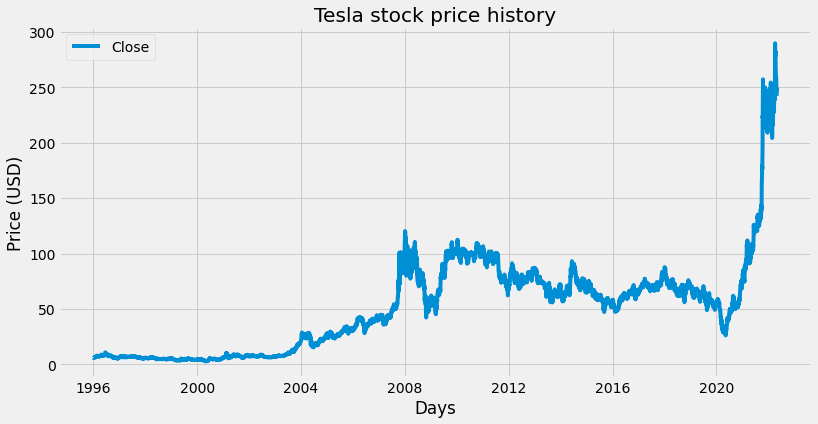

In [8]:
plt.figure(figsize = (12,6))
# plt.plot(df["Open"])
# plt.plot(df["High"])
# plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title('Tesla stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Close'], loc='upper left')
plt.show()

In [9]:
# Create a dataframe with only the Close Stock Price Column
data_target = df.filter(['Close'])

# Convert the dataframe to a numpy array to train the LSTM model
target = data_target.values

# Splitting the dataset into training and test
# Target Variable: Close stock price value

training_data_len = math.ceil(len(target)* 0.75) # training set has 75% of the data
training_data_len

# Normalizing data before model fitting using MinMaxScaler
# Feature Scaling

sc = MinMaxScaler(feature_range=(0,1))
training_scaled_data = sc.fit_transform(target)
training_scaled_data

array([[0.01143084],
       [0.01117208],
       [0.01104271],
       ...,
       [0.85214925],
       [0.85528388],
       [0.83473455]])

In [10]:
target

array([[  5.96819782],
       [  5.89390373],
       [  5.85675955],
       ...,
       [247.3500061 ],
       [248.25      ],
       [242.3500061 ]])

In [11]:
# Create a training dataset containing the last 180-day closing price values we want to use to estimate the 181st closing price value.
train_data = training_scaled_data[0:training_data_len  , : ]

X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train) # converting into numpy sequences to train the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Number of rows and columns: ', X_train.shape)

Number of rows and columns:  (4787, 180, 1)


In [12]:
!pip install -U protobuf==3.8.0

     |████████████████████████████████| 1.2 MB 7.3 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires protobuf>=3.9.2, but you have protobuf 3.8.0 which is incompatible.
tensorflow-metadata 1.7.0 requires protobuf<4,>=3.13, but you have protobuf 3.8.0 which is incompatible.
googleapis-common-protos 1.56.0 requires protobuf>=3.12.0, but you have protobuf 3.8.0 which is incompatible.
google-api-core 1.31.5 requires protobuf>=3.12.0; python_version > "3", but you have protobuf 3.8.0 which is incompatible.


In [13]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
150/150 [==============================] - 72s 402ms/step - loss: 0.0016
Epoch 2/10
150/150 [==============================] - 50s 332ms/step - loss: 5.1187e-04
Epoch 3/10
150/150 [==============================] - 53s 350ms/step - loss: 4.4919e-04
Epoch 4/10
150/150 [==============================] - 51s 342ms/step - loss: 4.5511e-04
Epoch 5/10
150/150 [==============================] - 51s 343ms/step - loss: 3.7144e-04
Epoch 6/10
150/150 [==============================] - 50s 332ms/step - loss: 3.7283e-04
Epoch 7/10
150/150 [==============================] - 50s 334ms/step - loss: 3.4445e-04
Epoch 8/10
150/150 [==============================] - 50s 333ms/step - loss: 3.0397e-04
Epoch 9/10
150/150 [==============================] - 50s 334ms/step - loss: 2.8776e-04
Epoch 10/10
150/150 [==============================] - 50s 336ms/step - loss: 2.9897e-04


In [14]:
# Getting the predicted stock price
test_data = training_scaled_data[training_data_len - 180: , : ]

#Create the x_test and y_test data sets
X_test = []
y_test =  target[training_data_len : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])

# Convert x_test to a numpy array
X_test = np.array(X_test)

#Reshape the data into the shape accepted by the LSTM
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)

Number of rows and columns:  (1655, 180, 1)


In [15]:
# Making predictions using the test dataset
predicted_stock_price = model.predict(X_test)
score = model.evaluate(X_test,y_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

52/52 [==============================] - 10s 128ms/step - loss: 9160.2969


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


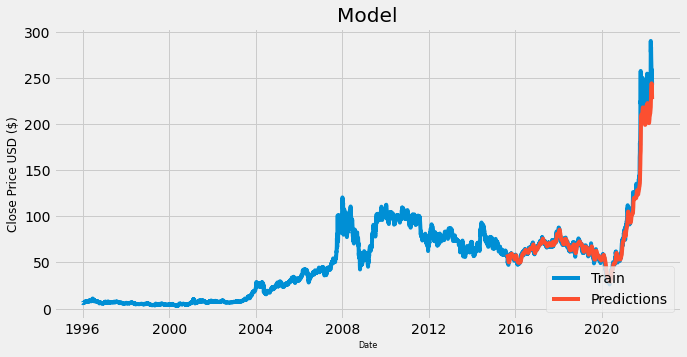

In [16]:
# Visualising the results
train = data_target[:training_data_len]
valid = data_target[training_data_len:]
valid['Predictions'] = predicted_stock_price
plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(df["Close"])
plt.plot(valid[[ 'Predictions']])
plt.legend(['Train', 'Predictions'], loc='lower right')
plt.show()

In [17]:
import numpy as np

In [21]:
from sklearn.metrics import r2_score

accu = np.sqrt(r2_score(valid['Close'],valid['Predictions']))


In [22]:
accu

0.9834853535525213

In [ ]:
valid

,Close,Predictions
Date,,
2019-10-21,189.759995,186.326492
2019-10-22,182.339996,186.566696
2019-10-23,186.149994,186.901917
2019-10-24,186.380005,187.299164
2019-10-25,187.889999,187.730347
...,...,...
2022-04-01,224.850006,208.671600
2022-04-04,233.889999,210.338074
2022-04-05,231.839996,212.080231
